In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import tensorflow as tf
from aml_dl.mdn.model.tf_model import tf_pushing_model

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

In [5]:
KMIX = 2

In [6]:
net = tf_pushing_model(dim_input = 4, n_hidden = 1, n_kernels = KMIX)
saver = tf.train.Saver()

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

## Load data

In [8]:
from aml_robot.box2d.data_manager import DataManager

In [9]:
data_manager = DataManager.from_file('data_test.pkl')

In [10]:
print data_manager.get_sample(0,'push_action')

[[ 0.          0.          0.04098435  0.99915979  1.52980049]]


In [11]:
data_x = data_manager.pack_data_x(['state_start','state_end'])

In [12]:
data_y = data_manager.pack_data_y()

In [13]:
print data_y

[[1.5298004918182597], [2.0434445991846713], [0.68247180603671653], [6.0566915120048854], [5.9127762581008891], [1.2013796716283738], [1.6941420757779846], [4.2643177561362791], [4.9225647455415018], [0.77227839288369415], [1.8133906988999167], [0.39041715698409957], [4.4854110626200097], [2.4331107307934938], [2.5605347602051687], [2.3230466969021215], [1.584700703820775], [3.0318140348660489], [3.5122224916131253], [4.7251271574864626], [4.0175487691984033], [4.8752073581718376], [4.6011997279725696], [5.5453745795211962], [3.3141676945464487], [1.0660913844372495], [5.7290896131483775], [5.0158923202185619], [3.5479948167476087], [4.8653257690578462], [1.905209021000732], [1.5681093399271622], [2.8285812093322029], [0.97753983616455564], [5.2389718172026294], [0.93766440392355721], [2.5327630430938703], [1.1032965135196884], [4.0537430765477342], [0.60083824749434234], [2.4504914725408207], [4.5277255898514497], [1.9984893897005078], [0.0020764800250803787], [1.294554883990584], [3.

In [14]:
h = sess.run(net['z_hidden'],feed_dict={net['x']: data_x})

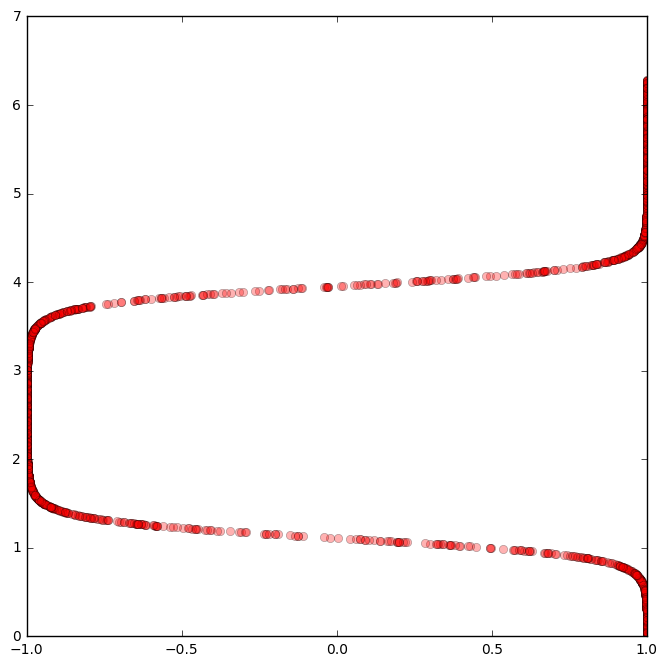

In [15]:
plt.figure(figsize=(8, 8))
plt.plot(h, data_y,'ro', alpha=0.3)
plt.show()

In [ ]:
N_EPOCHS = 10000#10000
loss = np.zeros(N_EPOCHS) # store the training progress here.
for i in range(N_EPOCHS):
  sess.run(net['train'],feed_dict={net['x']: data_x, net['y']: data_y})
  loss[i] = sess.run(net['loss'], feed_dict={net['x']: data_x, net['y']: data_y})

In [ ]:
######## SAVING MODEL #######
save_path = saver.save(sess, "push_model.ckpt")
print("Model saved in file: %s" % save_path)

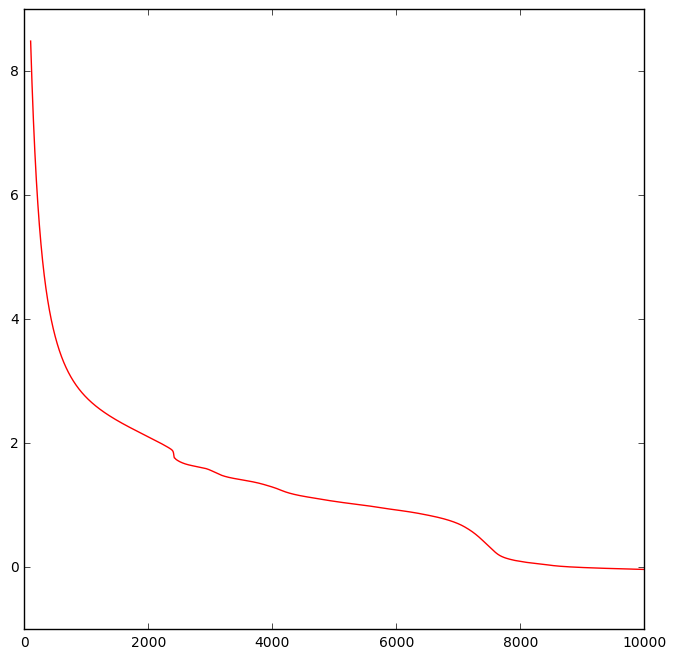

In [27]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, N_EPOCHS,1), loss[100:], 'r-')
plt.show()

In [28]:
h = sess.run(net['z_hidden'],feed_dict={net['x']: data_x})

In [29]:
N_SAMPLES = 1000
print N_SAMPLES
x_test = np.float32(np.random.uniform(-5.5, 5.5, (4, N_SAMPLES))).T
len(x_test)

1000


1000

In [30]:
h_test = sess.run(net['z_hidden'],feed_dict={net['x']: x_test})
NTEST = h_test.size
print NTEST
# x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

def get_pi_idx(x, pdf):
  N = pdf.size
  accumulate = 0
  for i in range(0, N):
    accumulate += pdf[i]
    if (accumulate >= x):
      return i
  print 'error with sampling ensemble'
  return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
  NTEST = h_test.size
  result = np.random.rand(NTEST, M) # initially random [0, 1]
  rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
  mu = 0
  std = 0
  idx = 0

  # transforms result into random ensembles
  for j in range(0, M):
    for i in range(0, NTEST):
      idx = get_pi_idx(result[i, j], out_pi[i])
      mu = out_mu[i, idx]
      std = out_sigma[i, idx]
      result[i, j] = mu + rn[i, j]*std
  return result

1000


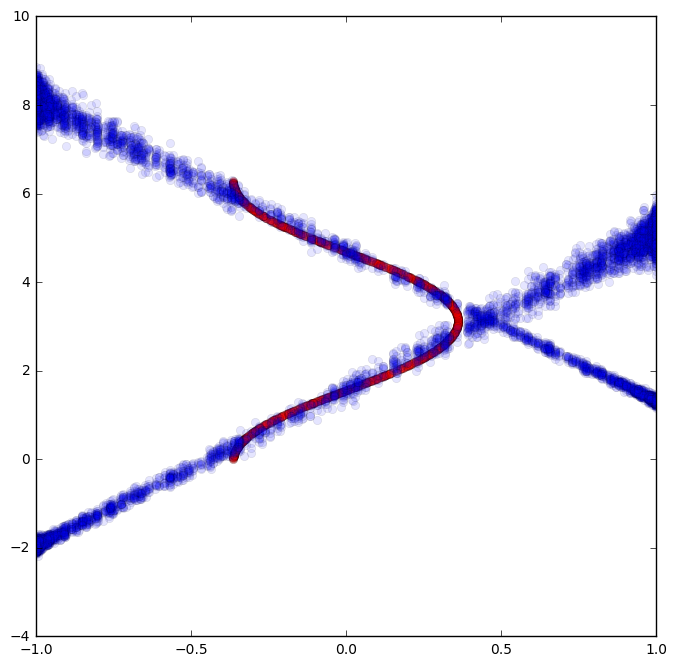

In [31]:
out_pi_test, out_sigma_test, out_mu_test = sess.run([net['pi'], net['sigma'], net['mu']], feed_dict={net['x']: x_test})

y_test = generate_ensemble(out_pi_test, out_mu_test, out_sigma_test)

plt.figure(figsize=(8, 8))
plt.plot(h,data_y,'ro', h_test,y_test,'bo',alpha=0.1)
plt.show()

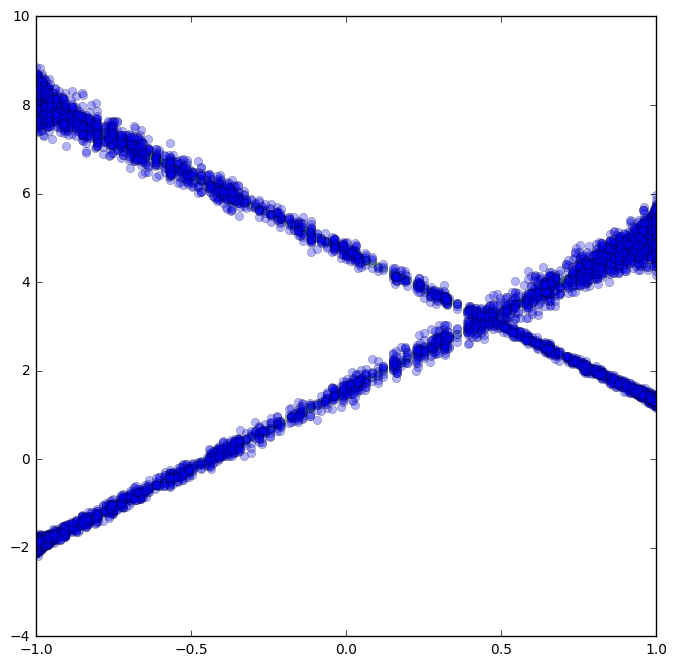

In [32]:
plt.figure(figsize=(8, 8))
plt.plot(h_test,out_mu_test,'go', h_test,y_test,'bo',alpha=0.3)
plt.show()

In [58]:
len(out_pi_test)
x_heatmap_label = np.float32(np.arange(-6,6,0.02))
y_heatmap_label = np.float32(np.arange(-6,6,0.02))

len(x_heatmap_label)

600

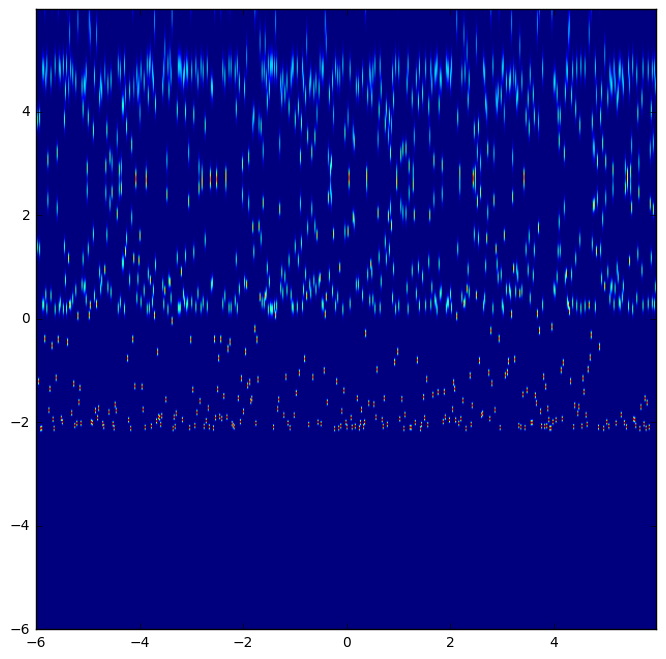

In [59]:


def custom_gaussian(x, mu, std):
  oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)
  x_norm = (x-mu)/std
  result = oneDivSqrtTwoPI*math.exp(-x_norm*x_norm/2)/std
  return result

def generate_heatmap(out_pi, out_mu, out_sigma, x_heatmap_label, y_heatmap_label):
  N = x_heatmap_label.size
  M = y_heatmap_label.size
  K = KMIX

  z = np.zeros((N, M)) # initially random [0, 1]

  mu = 0
  std = 0
  pi = 0

  # transforms result into random ensembles
  for k in range(0, K):
    for i in range(0, M):
      pi = out_pi[i, k]
      mu = out_mu[i, k]
      std = out_sigma[i, k]
      for j in range(0, N):
        z[N-j-1, i] += pi * custom_gaussian(y_heatmap_label[j], mu, std)

  return z

def draw_heatmap(xedges, yedges, heatmap):
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  plt.figure(figsize=(8, 8))
  plt.imshow(heatmap, extent=extent)
  plt.show()

z = generate_heatmap(out_pi_test, out_mu_test, out_sigma_test, x_heatmap_label, y_heatmap_label)
draw_heatmap(x_heatmap_label, y_heatmap_label, z)